In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

import numpy as np

In [2]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB").resize((1024, 1024))

input_points = [[[150 * 2, 170 * 2], [300 * 2, 250 * 2]]] # 2D localization of a window

inputs = processor(
   raw_image, 
   input_points=input_points,
   return_tensors="pt").to("cuda")

In [3]:
outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
   outputs.pred_masks.cpu(), 
   inputs["original_sizes"].cpu(), 
   inputs["reshaped_input_sizes"].cpu())

scores = outputs.iou_scores

In [4]:
len(masks[0][0])

3

In [5]:
scores

tensor([[[0.9281, 0.8449, 0.8715]]], device='cuda:0', grad_fn=<SliceBackward0>)

In [6]:
# Choose the mask with the highest confidence
best_mask = masks[0][0][scores.argmax()]
best_mask.shape

torch.Size([1024, 1024])

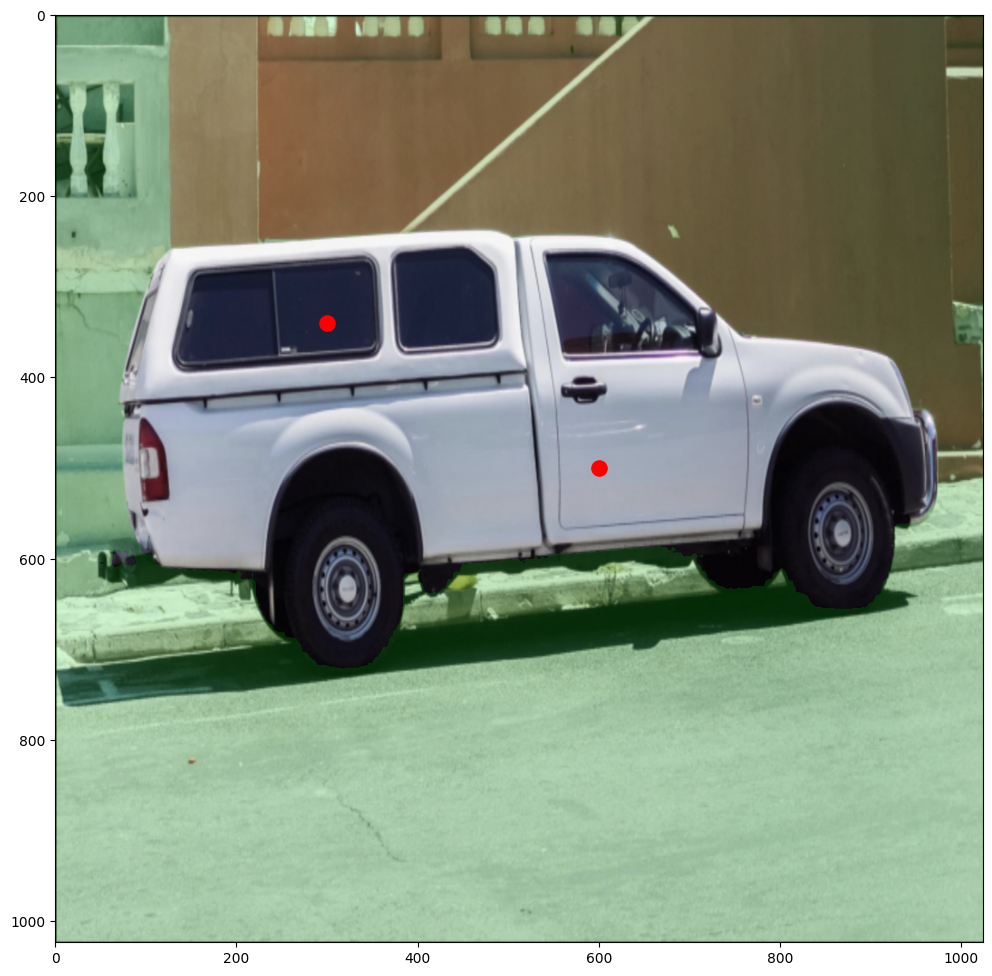

In [11]:
import matplotlib.pyplot as plt

# Create figure 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Display image
ax.imshow(raw_image)
    
# Create RGBA image
# xs, ys = np.where(best_mask)
# x1, x2 = xs.min(), xs.max()  
# y1, y2 = ys.min(), ys.max()

# best_mask[x1:x2, y1:y2] = 1
from scipy.ndimage import binary_dilation, binary_erosion

# selem = np.ones((11, 11), dtype=np.int32)
# dilated_mask = binary_dilation(best_mask, iterations=1)
# dilated_mask = binary_erosion(best_mask, iterations=20)
dilated_mask = best_mask

bg_transparent = np.zeros(dilated_mask.shape + (4, ), dtype=np.uint8)
bg_transparent[dilated_mask == 0] = [0, 255, 0, 127]  

ax.imshow(bg_transparent, alpha=0.3)

x_points, y_points = zip(*input_points[0])
plt.scatter(x_points, y_points, color='red', s=120)

plt.tight_layout()
plt.show()

In [8]:
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from diffusers.utils import load_image, make_image_grid

import torch

In [9]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/49 [00:00<?, ?it/s]

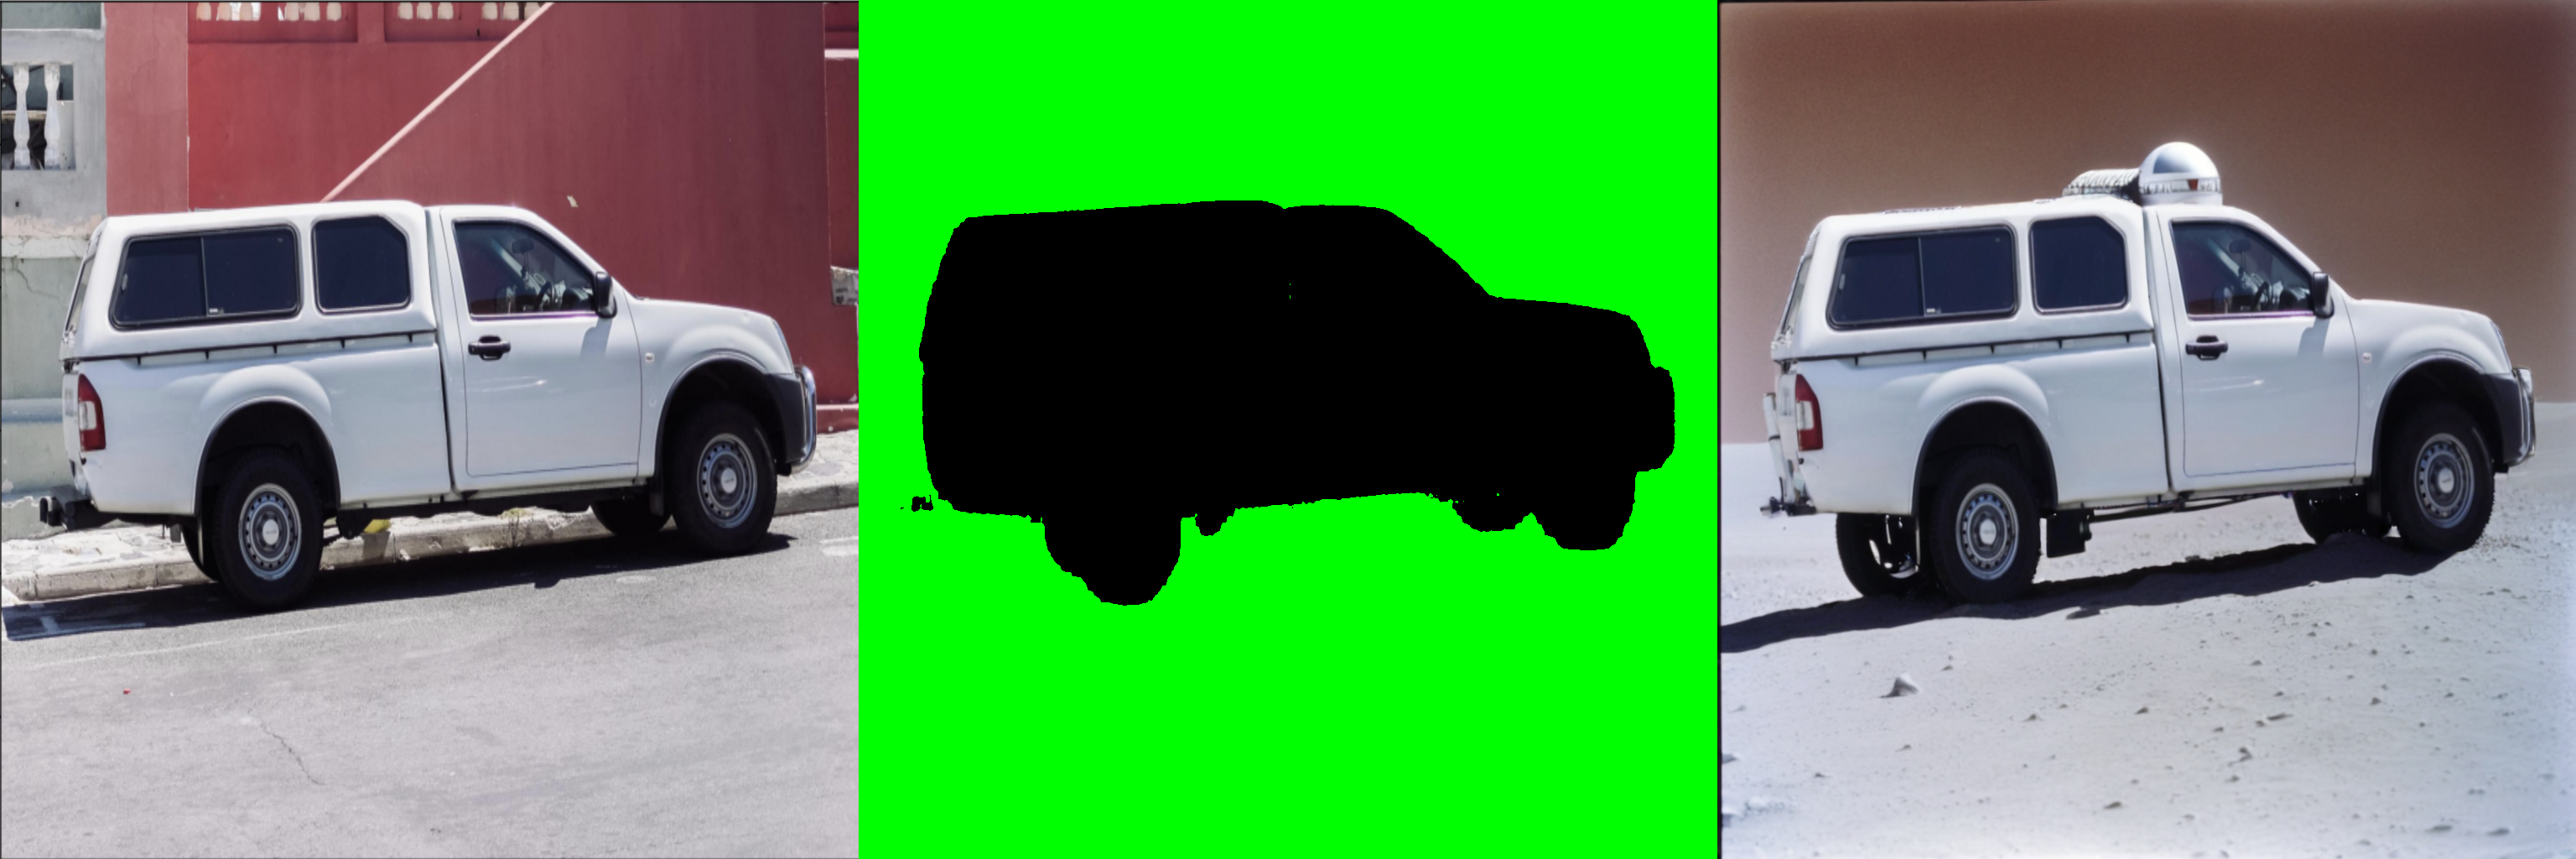

In [15]:
import matplotlib.pyplot as plt
import torch

prompt = "a car stuck in traffic in New York on a rainy day"
prompt = "a car driving on the beach in broad daylight"
prompt = "a car driving on the Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

mask_image = Image.fromarray(bg_transparent)
rand_gen = torch.manual_seed(74294536)
image = pipeline(
    prompt=prompt, 
    negative_prompt=negative_prompt, 
    image=raw_image, 
    mask_image=mask_image, 
    generator=rand_gen, 
    guidance_scale=7
).images[0]
fig = make_image_grid([raw_image, mask_image, image], rows=1, cols=3)
fig